In [1]:
import torch

import torch.nn as nn
import torchvision.transforms as transforms

from torchvision import datasets
from torchvision.utils import save_image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Define models

In [3]:
# noise 분포의 dimension
latent_dim = 100

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
    
        # Linear, BatchNorm, LeakyReLU 묶음 block
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1*28*28),
            nn.Tanh()
        )
    
    # 하나의 image를 만들어서 반환.
    # 이 image는 discriminator에 들어가게 됨.
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [4]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1*28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    # image에 대해 real, fake 여부를 확률로 반환. (real ~ 1, fake ~ 0)
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

In [5]:
print(Generator())

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)


In [6]:
print(Discriminator())

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


# Dataset

In [7]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
# colab basic에서는 max num_workers=2
# num_workers에 대한 내용 https://jybaek.tistory.com/799

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



# Training

In [8]:
# model initialize
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

# loss function
adversarial_loss = nn.BCELoss()
adversarial_loss.to(device)

# learning rate
lr = 0.0002

# optimizer
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
# 위의 lr과 betas 값은 일반적으로 생성자와 판별자에 대해 사용되는 hyperparameter 값.

In [9]:
import time

# 전체 epoch 수
epochs = 200
# sample_interval 배치 마다 결과 이미지를 출력함.
sample_interval = 2000
start_time = time.time()

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # real 이미지와 fake 이미지에 대한 정답 label 생성.
        real = torch.FloatTensor(imgs.size(0), 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(imgs.size(0), 1).fill_(0.0).to(device)

        real_imgs = imgs.to(device)

        """ fake 이미지 생성 """
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).to(device)
        generated_imgs = generator(z)

        """ 판별자(discriminator) 학습 """
        # 참고한 코드와 다르게 논문에 맞춰 discriminator를 먼저 학습합니다.
        optimizer_D.zero_grad()

        # discriminator의 Loss 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # update discriminator
        d_loss.backward()
        optimizer_D.step()

        """ 생성자(generator) 학습 """
        optimizer_G.zero_grad()

        # generator의 Loss 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)
        
        # update generator
        g_loss.backward()
        optimizer_G.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.516609] [G loss: 1.237676] [Elapsed time: 11.87s]
[Epoch 1/200] [D loss: 0.508005] [G loss: 1.204512] [Elapsed time: 23.58s]
[Epoch 2/200] [D loss: 0.563763] [G loss: 2.523177] [Elapsed time: 35.48s]
[Epoch 3/200] [D loss: 0.431739] [G loss: 2.368331] [Elapsed time: 47.35s]
[Epoch 4/200] [D loss: 0.518087] [G loss: 2.175791] [Elapsed time: 59.07s]
[Epoch 5/200] [D loss: 0.511368] [G loss: 0.970562] [Elapsed time: 70.89s]
[Epoch 6/200] [D loss: 0.317684] [G loss: 1.891010] [Elapsed time: 82.67s]
[Epoch 7/200] [D loss: 0.488581] [G loss: 0.992198] [Elapsed time: 95.28s]
[Epoch 8/200] [D loss: 0.389697] [G loss: 2.405047] [Elapsed time: 107.13s]
[Epoch 9/200] [D loss: 0.366187] [G loss: 2.355525] [Elapsed time: 118.95s]
[Epoch 10/200] [D loss: 0.556184] [G loss: 3.171861] [Elapsed time: 130.75s]
[Epoch 11/200] [D loss: 0.323780] [G loss: 1.761401] [Elapsed time: 142.51s]
[Epoch 12/200] [D loss: 0.395806] [G loss: 1.973573] [Elapsed time: 154.42s]
[Epoch 13/200] [D

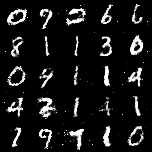

In [10]:
from IPython.display import Image

Image('30000.png')

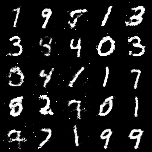

In [11]:
Image('40000.png')

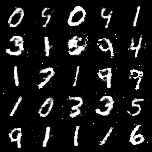

In [12]:
Image('50000.png')

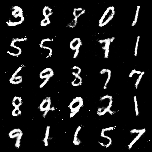

In [13]:
Image('60000.png')

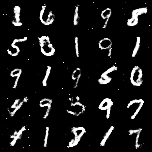

In [14]:
Image('70000.png')

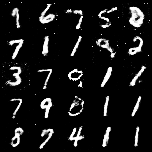

In [15]:
Image('80000.png')

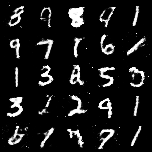

In [16]:
Image('90000.png')